In [1]:
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)
print(f"ROOT_DIR: {ROOT_DIR}")

ROOT_DIR: e:\OneDrive\Documents\GitHub\End_to_End_Projects\NYC_Taxi_Test_ML


In [ ]:
import sagemaker
import boto3
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.data_ingestion import load_taxi_data, fetch_weather_data
from src.feature_engineering import add_trip_datetime_features, add_rain_or_snow_column
from src.data_cleaning import *
from utils.visualizations import *

e:\anaconda3\envs\nyc_taxi_env\Lib\site-packages\pydantic\_internal\_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/17/25 18:23:35] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=760992;file://e:\anaconda3\envs\nyc_taxi_env\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=919751;file://e:\anaconda3\envs\nyc_taxi_env\Lib\site-packages\botocore\credentials.py#1278\1278]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Daniel\AppData\Local\sagemaker\sagemaker\config.yaml


In [3]:
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'dan-s3-gen-bucket1' # unique bucket name
print('Using bucket ' + bucket)

[02/17/25 18:23:37] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=342840;file://e:\anaconda3\envs\nyc_taxi_env\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=189439;file://e:\anaconda3\envs\nyc_taxi_env\Lib\site-packages\botocore\credentials.py#1278\1278]8;;\

Using bucket dan-s3-gen-bucket1


In [4]:
# Read taxi_zone_lookup.csv from local storage (requesting from URL gave 403 Forbidden)
lookup_path = os.path.join(ROOT_DIR, 'data/raw/taxi_zone_lookup.csv')
df_taxi_zones = pd.read_csv(lookup_path)

# Read parquet file from local storage
data_name = 'yellow_tripdata_2024-01.parquet'
file_path = os.path.join(ROOT_DIR, 'data/raw/', data_name)
df = load_taxi_data(file_path)
df.head()

✅ Loaded taxi dataset with 2964624 rows and 19 columns.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
df.shape

(2964624, 19)

In [6]:
# Getting feature names, unique values, and data types
columns = df.columns
for column in columns:
    dtype = df[column].dtype
    print(f"Feature: {column},  Unique Values: {df[column].nunique()},  Data Type: {dtype}")

Feature: VendorID,  Unique Values: 3,  Data Type: int32
Feature: tpep_pickup_datetime,  Unique Values: 1575706,  Data Type: datetime64[us]
Feature: tpep_dropoff_datetime,  Unique Values: 1574780,  Data Type: datetime64[us]
Feature: passenger_count,  Unique Values: 10,  Data Type: float64
Feature: trip_distance,  Unique Values: 4489,  Data Type: float64
Feature: RatecodeID,  Unique Values: 7,  Data Type: float64
Feature: store_and_fwd_flag,  Unique Values: 2,  Data Type: object
Feature: PULocationID,  Unique Values: 260,  Data Type: int32
Feature: DOLocationID,  Unique Values: 261,  Data Type: int32
Feature: payment_type,  Unique Values: 5,  Data Type: int64
Feature: fare_amount,  Unique Values: 8970,  Data Type: float64
Feature: extra,  Unique Values: 48,  Data Type: float64
Feature: mta_tax,  Unique Values: 8,  Data Type: float64
Feature: tip_amount,  Unique Values: 4192,  Data Type: float64
Feature: tolls_amount,  Unique Values: 1127,  Data Type: float64
Feature: improvement_surcharg

In [7]:
# Identify any duplicate rows
df.duplicated().sum()

0

In [8]:
df.describe()   

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.754204e+00,2024-01-17 00:46:36.431092,2024-01-17 01:02:13.208130,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-01-09 15:59:19.750000,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:23:52.250000,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01


**Feature Notes and Considerations** ([Data Dictionary Link](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)/[User Guide Link](https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf)):

**VendorID** - This should only have 2 possible values {1,2}, so a max of 6 suggests some sort of error(s) in the data.  
**tpep_pickup_datetime** - The data being explored is for 2024-01, therefore a minimum of 2002-01 suggests some sort of error(s) in the data.  
**tpep_dropoff_datetime** - Here we see a similar problem to `tpep_pickup_datetime`, we should check whether these errors occur on the same entry/entries.  
**passenger_count** - A max passenger count of 9 seems high, we should look into whether this is a possible value or a potential entry error. Also, a minimum passenger count of 0 shouldn't be possible.   
**trip_distance** - This is measured in miles according to the data dictionary, so 312,722.3 miles (>10x the circumference of Earth) is unlikely to say the least.  
**RatecodeID** - This should be an integer in {1,2,3,4,5,6}, so a max value of '99' is either an error or an inication of a missing value.   
**PULocationID** - This is within the correct range according to the lookup table.  
**DOLocationID** - This is within the correct range according to the lookup table.  
**payment_type** - This should be an integer in {1,2,3,4,5,6}, so a min of '0' is outside the range and should be looked into (5 = Unknown so remapping to 5 could be an option).  
**total_amount** - This feature is the planned target feature, the maximum value of $500 seems high but not entirely impossible based on my knowledge. We should look into this further if there is only one instance (or a very small number of instances) of an amount this high and if it still remains after other data cleaning. Also, the minimum value of -$900 could be an entry error.  
**fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee** - These features can be used to directly calculate `total_amount` and should be excluded or engineered in such a way that. Separately, all of these have at least one negative value, we should check to see if they correspond to the negative values for `total_amount`. Also, `Airport_fee` could be converted to an indicator feature instead to indicate whether the pickup occured at LaGuardia or JFK Airports, but I haven't decided whether to do that yet.   


There are several components of the intended target variable in the data such as fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, congestion_surcharge, Airport_fee. These should be removed, or altered if any are going to be included in the model. I will likely exclude some of them and modify others. After reading the documentation, the 'extra' feature ecompasses a few things that might be useful to our model. For example, there are $0.50 and $1 rush hour charges as well as an overnight charge. We can use the pickup datetime feature and create features such as the hour of the day, the day of the week, and whether the day is a holiday which could incur passengers additional fees.

## Removing Dates Outside of Dataset Scope

In [9]:
# Filter trips by dataset date allowing for either pickup or dropoff date to be within the dataset date range
df, df_outside_date = filter_trips_by_dataset_date(df, 'yellow_tripdata_2024-01.parquet')
df_outside_date

Filtering trips for 2024-01 (from 2023-12-31 to 2024-02-01) with a 1-day buffer
Total trips outside 2024-01: 8


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
10915,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,1.0,N,137,264,2,4.4,3.50,0.5,0.00,0.00,1.0,9.40,0.0,0.00
53119,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,1.0,N,170,170,3,-6.5,0.00,-0.5,0.00,0.00,-1.0,-10.50,-2.5,0.00
53120,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,1.0,N,170,170,3,6.5,0.00,0.5,0.00,0.00,1.0,10.50,2.5,0.00
1230169,2,2009-01-01 23:30:39,2009-01-02 00:01:39,1.0,10.99,1.0,N,237,264,2,45.0,3.50,0.5,0.00,0.00,1.0,50.00,0.0,0.00
2558056,2,2009-01-01 00:24:09,2009-01-01 01:13:00,2.0,10.88,1.0,N,138,264,2,50.6,9.25,0.5,0.00,6.94,1.0,68.29,0.0,0.00
2822633,2,2024-02-01 00:00:39,2024-02-01 00:12:08,5.0,2.22,1.0,N,186,79,1,13.5,1.00,0.5,3.70,0.00,1.0,22.20,2.5,0.00
2822693,2,2024-02-01 00:00:17,2024-02-01 00:20:13,1.0,8.93,1.0,N,138,152,2,36.6,6.00,0.5,0.00,6.94,1.0,52.79,0.0,1.75
2823026,2,2024-02-01 00:01:15,2024-02-01 00:06:30,1.0,1.10,1.0,N,161,234,1,7.9,1.00,0.5,2.58,0.00,1.0,15.48,2.5,0.00


## Feature Engineering for Datetime (& weather attempt)

In [10]:
# The following code attempts to fetch weather data using the Weather API or uses the local weather data file if it was already fetched
api_key = 'H8Z34NJDK8A32RJ8BN22YLJVM'
weather_df = fetch_weather_data(data_name, api_key, save_path=ROOT_DIR + '/data/weather/')
weather_df.head()

Weather data for 2024-01 found locally. Loading from file...


,datetime,precip,precipprob,snow,snowdepth,preciptype,icon
0,2023-12-31 00:00:00,0.0,0.0,0.0,0.0,NaN,partly-cloudy-night
1,2023-12-31 01:00:00,0.0,0.0,0.0,0.0,NaN,cloudy
2,2023-12-31 02:00:00,0.0,0.0,0.0,0.0,NaN,cloudy
3,2023-12-31 03:00:00,0.0,0.0,0.0,0.0,NaN,cloudy
4,2023-12-31 04:00:00,0.0,0.0,0.0,0.0,NaN,cloudy


In [11]:
# Add column rain_or_snow to the trips dataframe
df = add_rain_or_snow_column(df, weather_df)

In [12]:
# Adding datetime engineered features
df = add_trip_datetime_features(df, drop_original=True)
columns = df.columns

## Cleaning Data

### Checking

In [13]:
# Filter rows where total_amount is negative
negative_total_amount_df = df[df['total_amount'] < 0]

# Display the number of negative transactions
print(f"Found {negative_total_amount_df.shape[0]} trips with negative total amounts.")

# Show the first few rows of the filtered data
negative_total_amount_df.sample(10)

Found 35503 trips with negative total amounts.


,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,rain_or_snow,trip_duration_minutes,pickup_hour,pickup_day_of_week,is_holiday
263029,2,1.0,0.45,1.0,N,143,143,4,-5.1,0.0,...,0.00,-1.0,-9.10,-2.5,0.00,0,2.350000,11,3,0
1127268,2,1.0,0.43,1.0,N,239,142,3,-5.1,0.0,...,0.00,-1.0,-9.10,-2.5,0.00,0,3.066667,13,5,0
2939260,2,1.0,0.01,2.0,N,161,161,3,-70.0,-5.0,...,0.00,-1.0,-79.00,-2.5,0.00,0,1.033333,19,2,0
1568140,2,1.0,6.92,1.0,N,132,76,2,-27.5,-1.0,...,0.00,-1.0,-31.75,0.0,-1.75,0,12.166667,0,3,0
292029,2,1.0,0.33,1.0,N,138,138,3,-4.4,-7.5,...,0.00,-1.0,-15.15,0.0,-1.75,0,2.450000,16,3,0
1112274,2,1.0,1.65,1.0,N,148,88,4,-11.4,0.0,...,0.00,-1.0,-15.40,-2.5,0.00,0,9.850000,11,5,0
481088,2,2.0,1.68,1.0,N,170,234,2,-10.7,0.0,...,0.00,-1.0,-14.70,-2.5,0.00,0,8.483333,13,5,0
675662,2,2.0,18.03,2.0,N,132,48,4,-70.0,-5.0,...,-6.94,-1.0,-87.69,-2.5,-1.75,0,41.783333,19,0,0
1001766,2,2.0,0.95,1.0,N,170,161,4,-9.3,0.0,...,0.00,-1.0,-13.30,-2.5,0.00,0,7.816667,9,4,0
916624,2,1.0,1.30,1.0,N,186,161,2,-14.9,0.0,...,0.00,-1.0,-18.90,-2.5,0.00,0,16.766667,13,3,0


In [14]:
negative_total_amount_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,rain_or_snow,trip_duration_minutes,pickup_hour,pickup_day_of_week,is_holiday
count,35503.0,35501.000000,35503.000000,35501.000000,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000,...,35503.000000,35503.000000,35503.000000,35501.000000,35501.000000,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000
mean,2.0,1.336357,3.039378,1.176671,160.484438,159.161310,3.366617,-20.029414,-0.944090,-0.484903,...,-0.497771,-0.999848,-25.163185,-2.029753,-0.242578,0.258373,12.038889,14.052362,2.907247,0.058953
std,0.0,0.729433,5.155489,0.668105,62.039897,69.474599,0.840736,27.338040,1.366735,0.085727,...,2.477389,0.015903,28.420371,0.976973,0.604713,0.672520,20.458943,6.193429,1.980253,0.235540
min,2.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-899.000000,-7.500000,-0.500000,...,-80.000000,-1.000000,-900.000000,-2.500000,-1.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,1.000000,0.490000,1.000000,132.000000,107.000000,3.000000,-21.200000,-1.000000,-0.500000,...,0.000000,-1.000000,-25.900000,-2.500000,0.000000,0.000000,3.566667,10.000000,1.000000,0.000000
50%,2.0,1.000000,1.200000,1.000000,161.000000,161.000000,4.000000,-10.700000,0.000000,-0.500000,...,0.000000,-1.000000,-15.700000,-2.500000,0.000000,0.000000,8.483333,15.000000,3.000000,0.000000
75%,2.0,1.000000,2.810000,1.000000,230.000000,230.000000,4.000000,-6.500000,0.000000,-0.500000,...,0.000000,-1.000000,-11.200000,-2.500000,0.000000,0.000000,15.950000,19.000000,5.000000,0.000000
max,2.0,8.000000,157.250000,6.000000,265.000000,265.000000,4.000000,0.000000,2.500000,0.500000,...,6.940000,1.000000,-1.000000,0.000000,0.000000,3.000000,2133.333333,23.000000,6.000000,1.000000


There are many trips with negative values for all cost-related features. A lot of these come from no charge or disputed payment types which suggests negative values are indicative or refund-type payments. I will exclude these types of trips for now, but this should be looked into in more detail.

### Filtering

In [15]:
# Filter rows where total_amount is negative
df, negative_total_amount_df = remove_negative_total_amount(df)

# Filter trips by long duration (TLC rules: trips cannot last more than 12 hours)
df, df_long_duration = remove_long_trips(df, max_hours=12)

# Filter trips with extemely low duration (less than 1 minute)
df, df_low_duration = remove_short_trips(df, min_minutes=1)

# Add estimated mph column and filter trips with extremely high speed (more than 90 mph) and extremely low speed (less than 0.5 mph)
df = add_estimated_speed(df)
df, df_high_speed = remove_high_speed_trips(df, max_mph=90)
df, df_low_speed = remove_low_speed_trips(df, min_mph=1)
# df = df.drop(columns=['est_avg_mph','trip_duration_hours'])
df = df.drop(columns=['trip_duration_hours'])

Removed 35503 trips with negative total amounts.
Dropped 1599 trips exceeding 12 hours.
Dropped 29955 trips shorter than 1 minutes.


e:\OneDrive\Documents\GitHub\End_to_End_Projects\NYC_Taxi_Test_ML\src\data_cleaning.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['est_avg_mph'].replace([float('inf'), -float('inf')], np.nan, inplace=True)


Dropped 117 trips exceeding 90 mph.
Dropped 37616 trips with est_avg_mph < 1 mph.


### Remapping

In [16]:
# updating the data types of a few columns
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype('Int32')
df['RatecodeID'] = df['RatecodeID'].astype('Int32')

print(df['store_and_fwd_flag'].unique())
print(df['RatecodeID'].unique())

<IntegerArray>
[0, <NA>, 1]
Length: 3, dtype: Int32
<IntegerArray>
[1, 2, 4, <NA>, 3, 5, 99, 6]
Length: 8, dtype: Int32


In [17]:
# Converting values to missing values
df = convert_value_to_missing(df, 'RatecodeID', [99])
df = convert_value_to_missing(df, 'payment_type', [0])
df = convert_value_to_missing(df, 'passenger_count', [0])

Replaced 26760 occurrences of '[99]' with NaN in 'RatecodeID'.
Replaced 117026 occurrences of '[0]' with NaN in 'payment_type'.
Replaced 30486 occurrences of '[0]' with NaN in 'passenger_count'.


## Visualizing

In [18]:
print(columns)

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'Airport_fee', 'rain_or_snow', 'trip_duration_minutes', 'pickup_hour',
       'pickup_day_of_week', 'is_holiday'],
      dtype='object')


In [19]:
# Define feature lists
drop_columns = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
categorical_features = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'pickup_day_of_week', 'pickup_hour', 'is_holiday','rain_or_snow']
numerical_features = ['passenger_count', 'trip_distance', 'trip_duration_minutes']

# Convert feature lists to sets
drop_set = set(drop_columns)
cat_set = set(categorical_features)
num_set = set(numerical_features)

# Get the union of all features
all_features = drop_set | cat_set | num_set  # Union of all feature sets

# Check if all columns exist in df
df_columns = set(df.columns) - {'total_amount'}  # Exclude target variable
missing_columns = all_features - df_columns
extra_columns = df_columns - all_features  # Columns that exist in df but are not in any feature list

if missing_columns:
    print(f"Missing columns (in feature lists but not in df): {missing_columns}")
else:
    print("All specified columns exist in df!")

# Check for duplicate columns across feature sets
overlapping_features = (drop_set & cat_set) | (drop_set & num_set) | (cat_set & num_set)

if overlapping_features:
    print(f"Warning: The following columns are duplicated across categories: {overlapping_features}")
else:
    print("No duplicate columns found across feature lists!")

# Check if any columns are left out
if extra_columns:
    print(f"Warning: These columns exist in df but are NOT assigned to any feature list: {extra_columns}")
else:
    print("No columns were left out of feature assignment!")


All specified columns exist in df!
No duplicate columns found across feature lists!


In [20]:
# Drop columns
df = df.drop(columns=drop_columns)

In [21]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,rain_or_snow,trip_duration_minutes,pickup_hour,pickup_day_of_week,is_holiday,est_avg_mph
count,2.859826e+06,2.712314e+06,2.859826e+06,2716040.0,2742800.0,2.859826e+06,2.859826e+06,2.742800e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06
mean,1.757566e+00,1.354240e+00,3.303204e+00,1.05585,0.00396,1.662685e+02,1.653332e+02,1.183288e+00,2.729178e+01,2.630933e-01,1.501725e+01,1.421093e+01,2.871884e+00,5.231997e-02,1.151602e+01
std,4.299161e-01,8.437677e-01,4.394803e+00,0.31731,0.062802,6.348580e+01,6.926504e+01,4.513845e-01,2.157556e+01,6.841521e-01,1.214719e+01,5.690732e+00,1.933865e+00,2.226715e-01,6.690526e+00
min,1.000000e+00,1.000000e+00,2.000000e-02,1.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000927e+00
25%,2.000000e+00,1.000000e+00,1.030000e+00,1.0,0.0,1.320000e+02,1.140000e+02,1.000000e+00,1.548000e+01,0.000000e+00,7.316667e+00,1.100000e+01,1.000000e+00,0.000000e+00,7.402693e+00
50%,2.000000e+00,1.000000e+00,1.700000e+00,1.0,0.0,1.620000e+02,1.620000e+02,1.000000e+00,2.016000e+01,0.000000e+00,1.175000e+01,1.500000e+01,3.000000e+00,0.000000e+00,9.675705e+00
75%,2.000000e+00,1.000000e+00,3.200000e+00,1.0,0.0,2.340000e+02,2.340000e+02,1.000000e+00,2.856000e+01,0.000000e+00,1.876667e+01,1.900000e+01,5.000000e+00,0.000000e+00,1.312314e+01
max,6.000000e+00,9.000000e+00,2.332500e+02,6.0,1.0,2.650000e+02,2.650000e+02,4.000000e+00,1.617500e+03,3.000000e+00,6.950833e+02,2.300000e+01,6.000000e+00,1.000000e+00,8.887372e+01


In [22]:
# Checking missingness in the data
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0].index  # Storing column names with missing values
missing_values_prop = missing_values[missing_values > 0] / df.shape[0]  # proportion of missing values
missing_rows = df[columns_with_missing_values].isnull().all(axis=1) # Checking if rows with missing values are the same

print(f"Missing value counts:\n{missing_values}\n")
print(f"proportion of missing values:\n{missing_values_prop}\n")
print(f"All columns with missing values are missing on the same rows: {missing_rows.all()}")

Missing value counts:
VendorID                      0
passenger_count          147512
trip_distance                 0
RatecodeID               143786
store_and_fwd_flag       117026
PULocationID                  0
DOLocationID                  0
payment_type             117026
total_amount                  0
rain_or_snow                  0
trip_duration_minutes         0
pickup_hour                   0
pickup_day_of_week            0
is_holiday                    0
est_avg_mph                   0
dtype: int64

proportion of missing values:
passenger_count       0.051581
RatecodeID            0.050278
store_and_fwd_flag    0.040921
payment_type          0.040921
dtype: float64

All columns with missing values are missing on the same rows: False


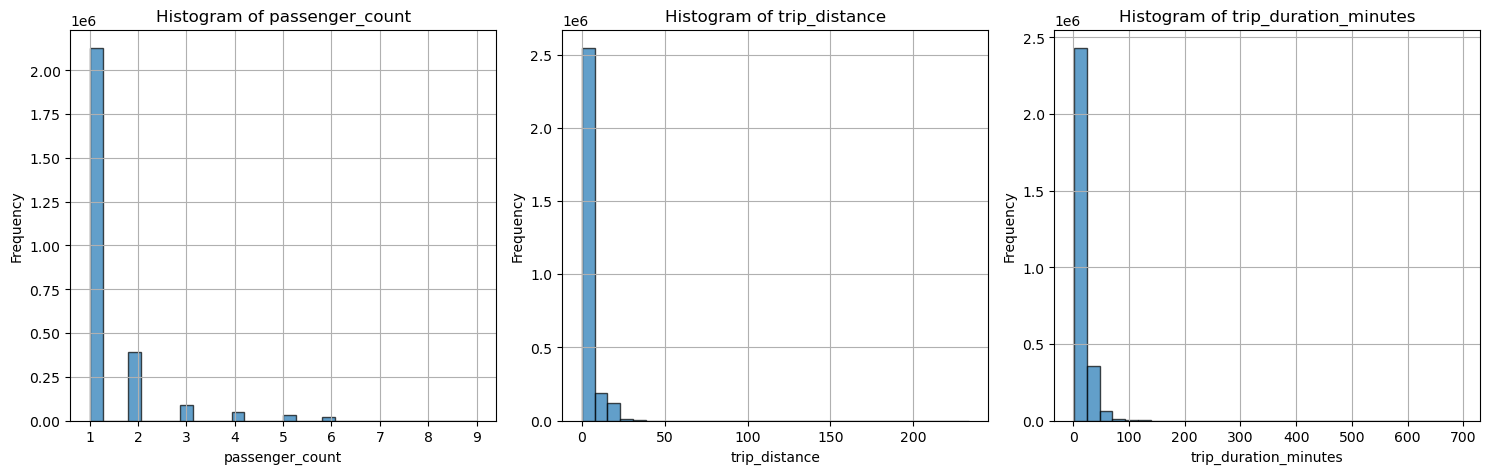

In [23]:
plot_numerical_histograms(df, numerical_features)

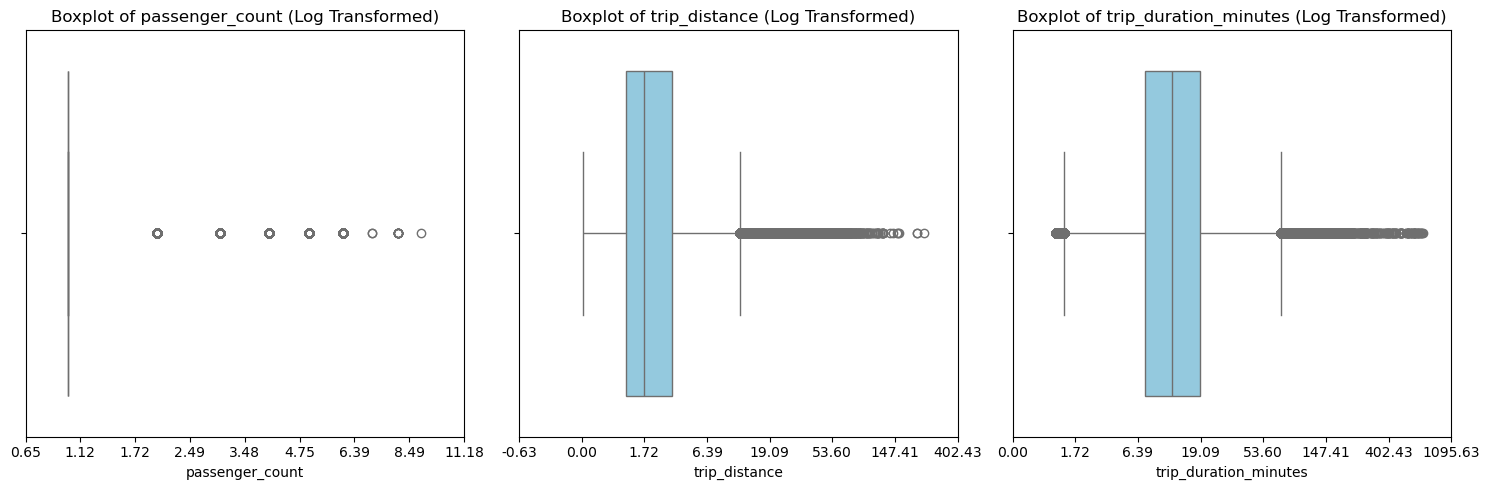

In [24]:
plot_numerical_boxplots(df, numerical_features, log_transform=True)

In [25]:
# Get the x largest trip distances
top_10_trip_distances = df.nlargest(10, 'trip_distance')
print(top_10_trip_distances)


         VendorID  passenger_count  trip_distance  RatecodeID  \
87613           2              1.0         233.25           4   
1005642         2              1.0         210.82           5   
1433039         1              1.0         210.20           5   
2018279         2              1.0         157.25           5   
2155237         2              1.0         155.56           5   
2403502         1              1.0         153.20           1   
526561          2              1.0         142.62           4   
1370751         2              2.0         135.82           5   
1245082         2              1.0         122.47           4   
1154011         2              5.0         120.86           3   

         store_and_fwd_flag  PULocationID  DOLocationID  payment_type  \
87613                     0           168           265           2.0   
1005642                   0           168           265           2.0   
1433039                   0           132           265          

Filtered 387513 trips above the IQR threshold.


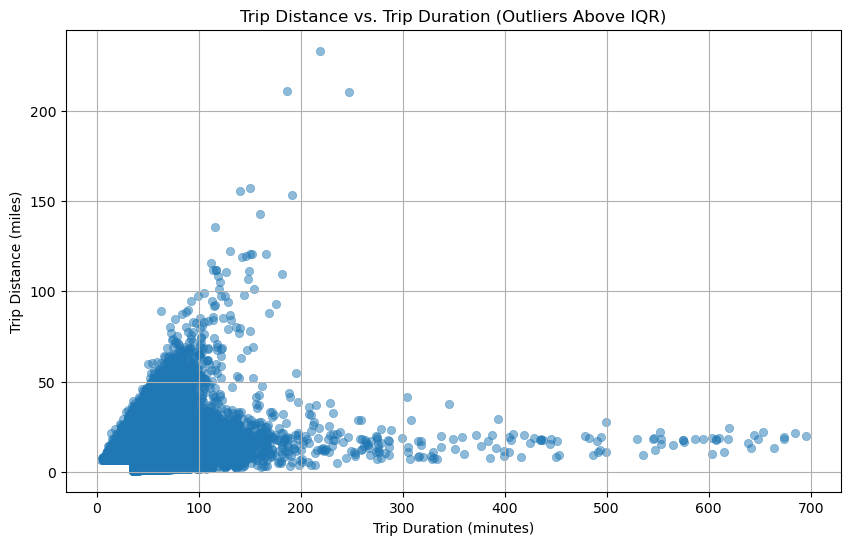

In [26]:
# Plot trip distance vs. trip duration for trips above the IQR
plot_trip_outliers(df)

In [27]:
# plot trip distance, trip duration, and estimated speed for trips above the trip duration IQR
plot_trip_outliers_3d_interactive(df) # this 3D interactive plot will open in a browser

Filtered 387513 trips above the IQR threshold.


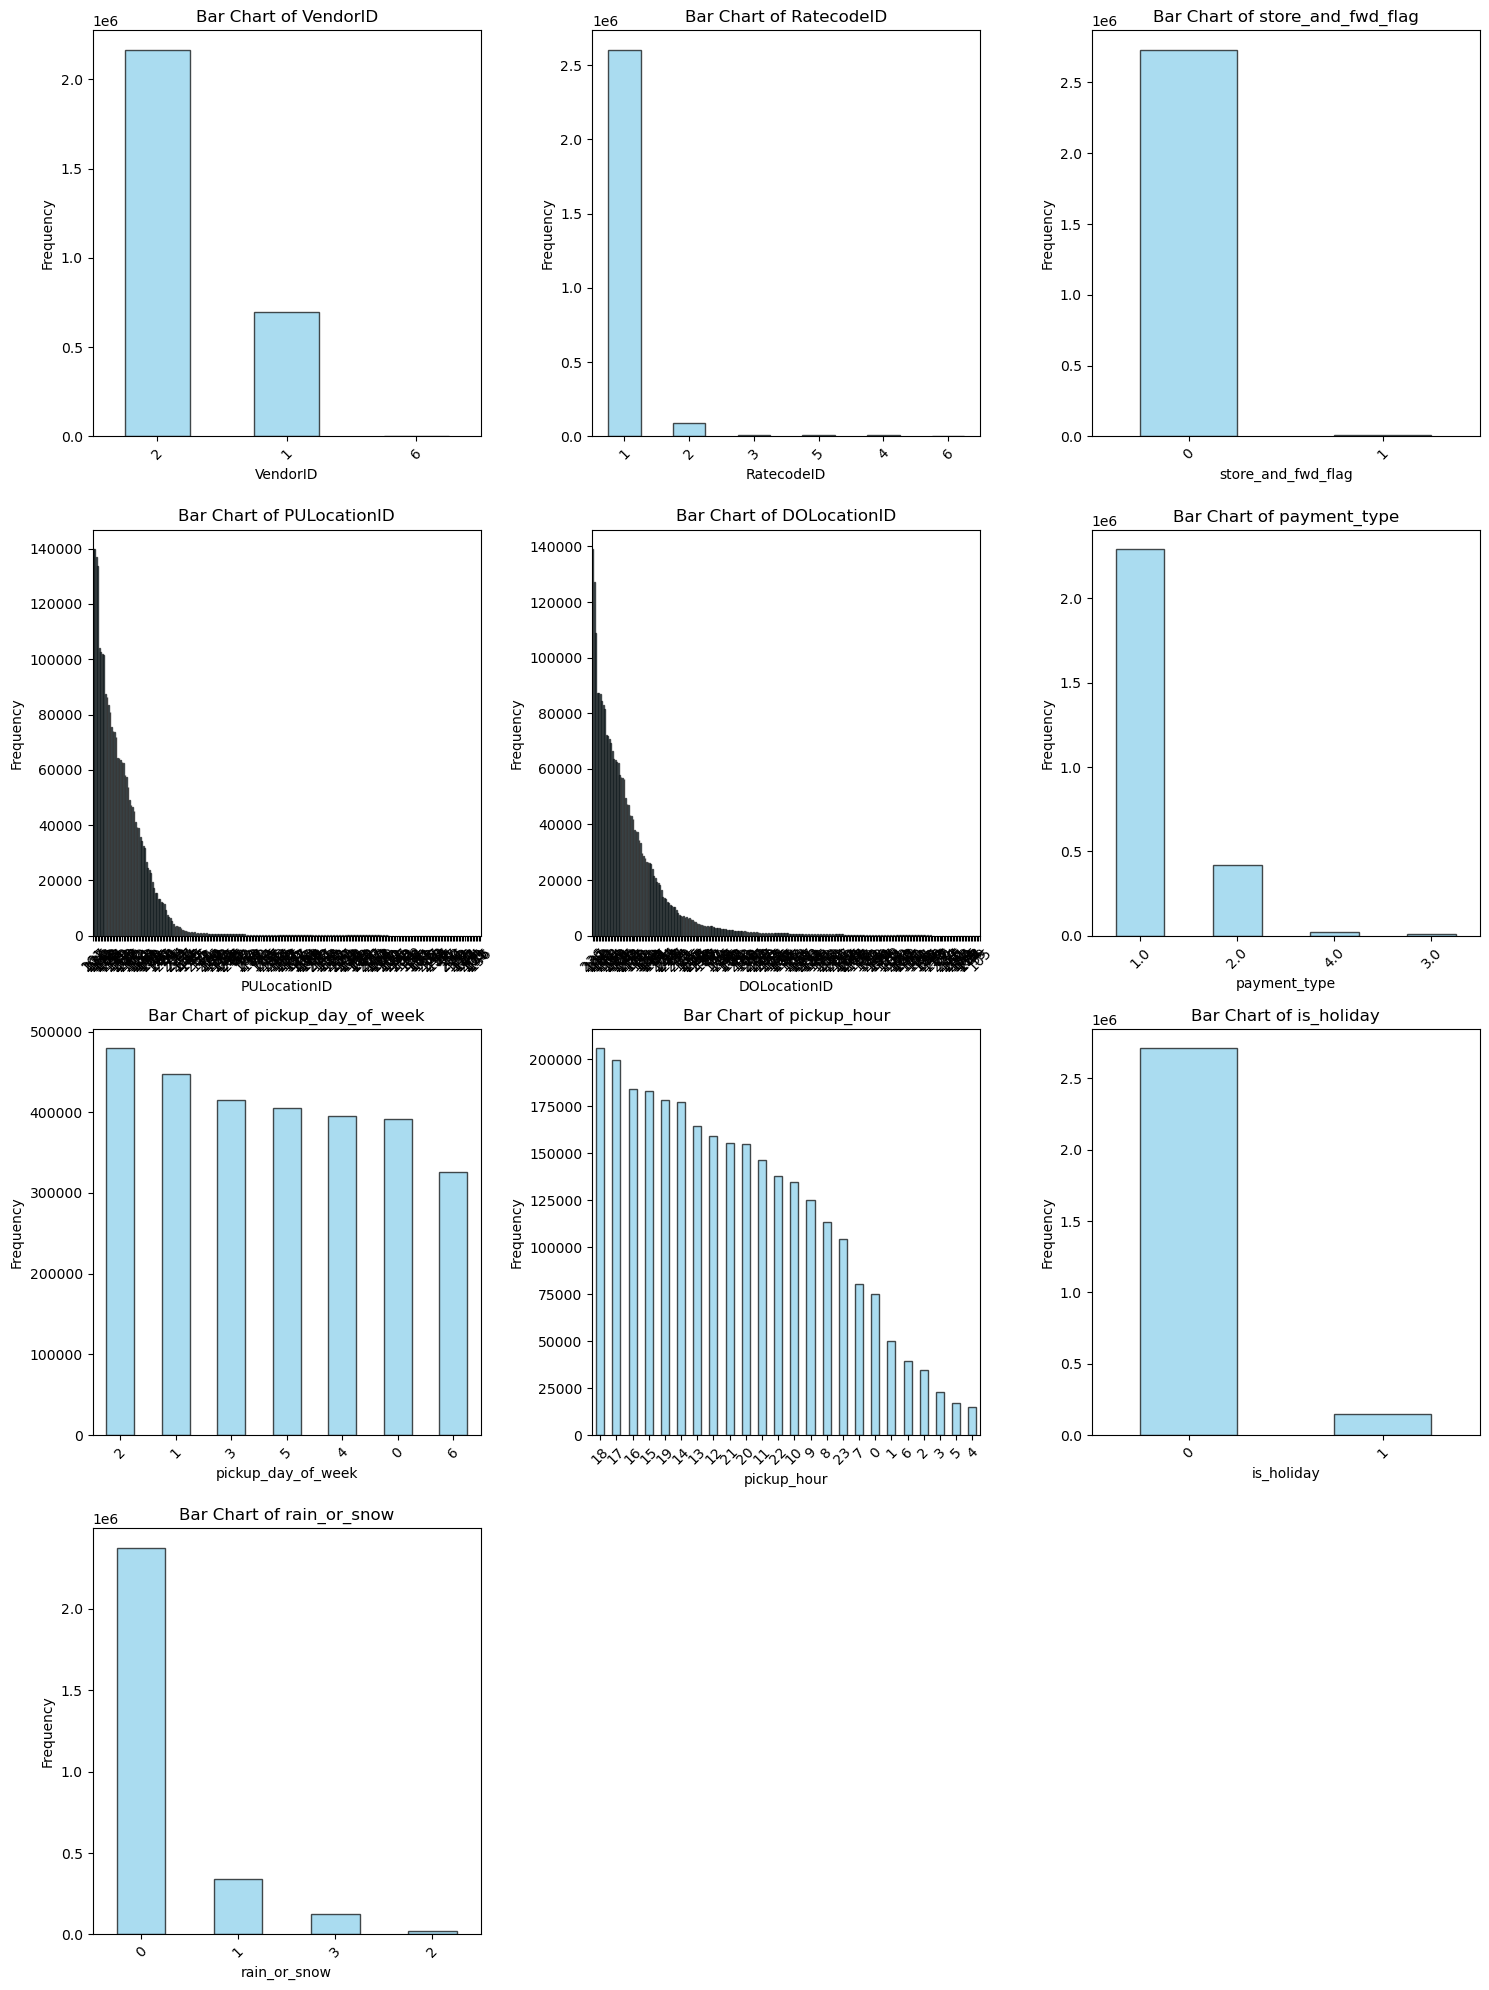

In [28]:
plot_categorical_bars(df, categorical_features, max_cols=3)

In [29]:
df.drop(columns=['est_avg_mph'], inplace=True)

## Final Checks

In [30]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,rain_or_snow,trip_duration_minutes,pickup_hour,pickup_day_of_week,is_holiday
count,2.859826e+06,2.712314e+06,2.859826e+06,2716040.0,2742800.0,2.859826e+06,2.859826e+06,2.742800e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06,2.859826e+06
mean,1.757566e+00,1.354240e+00,3.303204e+00,1.05585,0.00396,1.662685e+02,1.653332e+02,1.183288e+00,2.729178e+01,2.630933e-01,1.501725e+01,1.421093e+01,2.871884e+00,5.231997e-02
std,4.299161e-01,8.437677e-01,4.394803e+00,0.31731,0.062802,6.348580e+01,6.926504e+01,4.513845e-01,2.157556e+01,6.841521e-01,1.214719e+01,5.690732e+00,1.933865e+00,2.226715e-01
min,1.000000e+00,1.000000e+00,2.000000e-02,1.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00,1.030000e+00,1.0,0.0,1.320000e+02,1.140000e+02,1.000000e+00,1.548000e+01,0.000000e+00,7.316667e+00,1.100000e+01,1.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.700000e+00,1.0,0.0,1.620000e+02,1.620000e+02,1.000000e+00,2.016000e+01,0.000000e+00,1.175000e+01,1.500000e+01,3.000000e+00,0.000000e+00
75%,2.000000e+00,1.000000e+00,3.200000e+00,1.0,0.0,2.340000e+02,2.340000e+02,1.000000e+00,2.856000e+01,0.000000e+00,1.876667e+01,1.900000e+01,5.000000e+00,0.000000e+00
max,6.000000e+00,9.000000e+00,2.332500e+02,6.0,1.0,2.650000e+02,2.650000e+02,4.000000e+00,1.617500e+03,3.000000e+00,6.950833e+02,2.300000e+01,6.000000e+00,1.000000e+00


In [31]:
df.shape

(2859826, 14)

In [32]:
# missing values
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0].index  # Storing column names with missing values
missing_values_prop = missing_values[missing_values > 0] / df.shape[0]  # proportion of missing values
missing_values, missing_values_prop

(VendorID                      0
 passenger_count          147512
 trip_distance                 0
 RatecodeID               143786
 store_and_fwd_flag       117026
 PULocationID                  0
 DOLocationID                  0
 payment_type             117026
 total_amount                  0
 rain_or_snow                  0
 trip_duration_minutes         0
 pickup_hour                   0
 pickup_day_of_week            0
 is_holiday                    0
 dtype: int64,
 passenger_count       0.051581
 RatecodeID            0.050278
 store_and_fwd_flag    0.040921
 payment_type          0.040921
 dtype: float64)

## Spltting data into features and target

In [33]:
# # Split data in input and target
# y = df['total_amount']
# X = df.drop(columns='total_amount')

# # Save the cleaned data to a new parquet file
# cleaned_data_name = 'cleaned_' + data_name
# df.to_parquet(f'data/{cleaned_data_name}')

